# Set up

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm

C:\Users\qt49\AppData\Local\Temp\ipykernel_25944\2138848141.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [2]:
X_train, y_train = torch.load("data/brats_train_uncrop.pt")
X_val, y_val = torch.load("data/brats_val_uncrop.pt")
X_test, y_test = torch.load("data/brats_test_uncrop.pt")

# Preprocess

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]  # (C, H, W), already normalized
        mask = self.y[idx]  # (H, W)

        if torch.any(mask > 3):
            print(f"Sample {idx} has label > 3. Clamping.")
            mask = torch.clamp(mask, 0, 3)

        if self.transform:
            img = self.transform(img)

        return img, mask


In [4]:
# Transform pipeline
# transform = tio.Compose([
#     # tio.Resize((1, 256, 256)),                  # Only if CUDA out of memory
#     tio.RescaleIntensity(percentiles=(0, 99)),  # Percentile stretching
#     # tio.ZNormalization(),                       # Standardization
# ])

train_dataset = BraTSDataset(X_train, y_train)
test_dataset = BraTSDataset(X_test, y_test)

img, mask = train_dataset[0]
print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)

Image shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128])


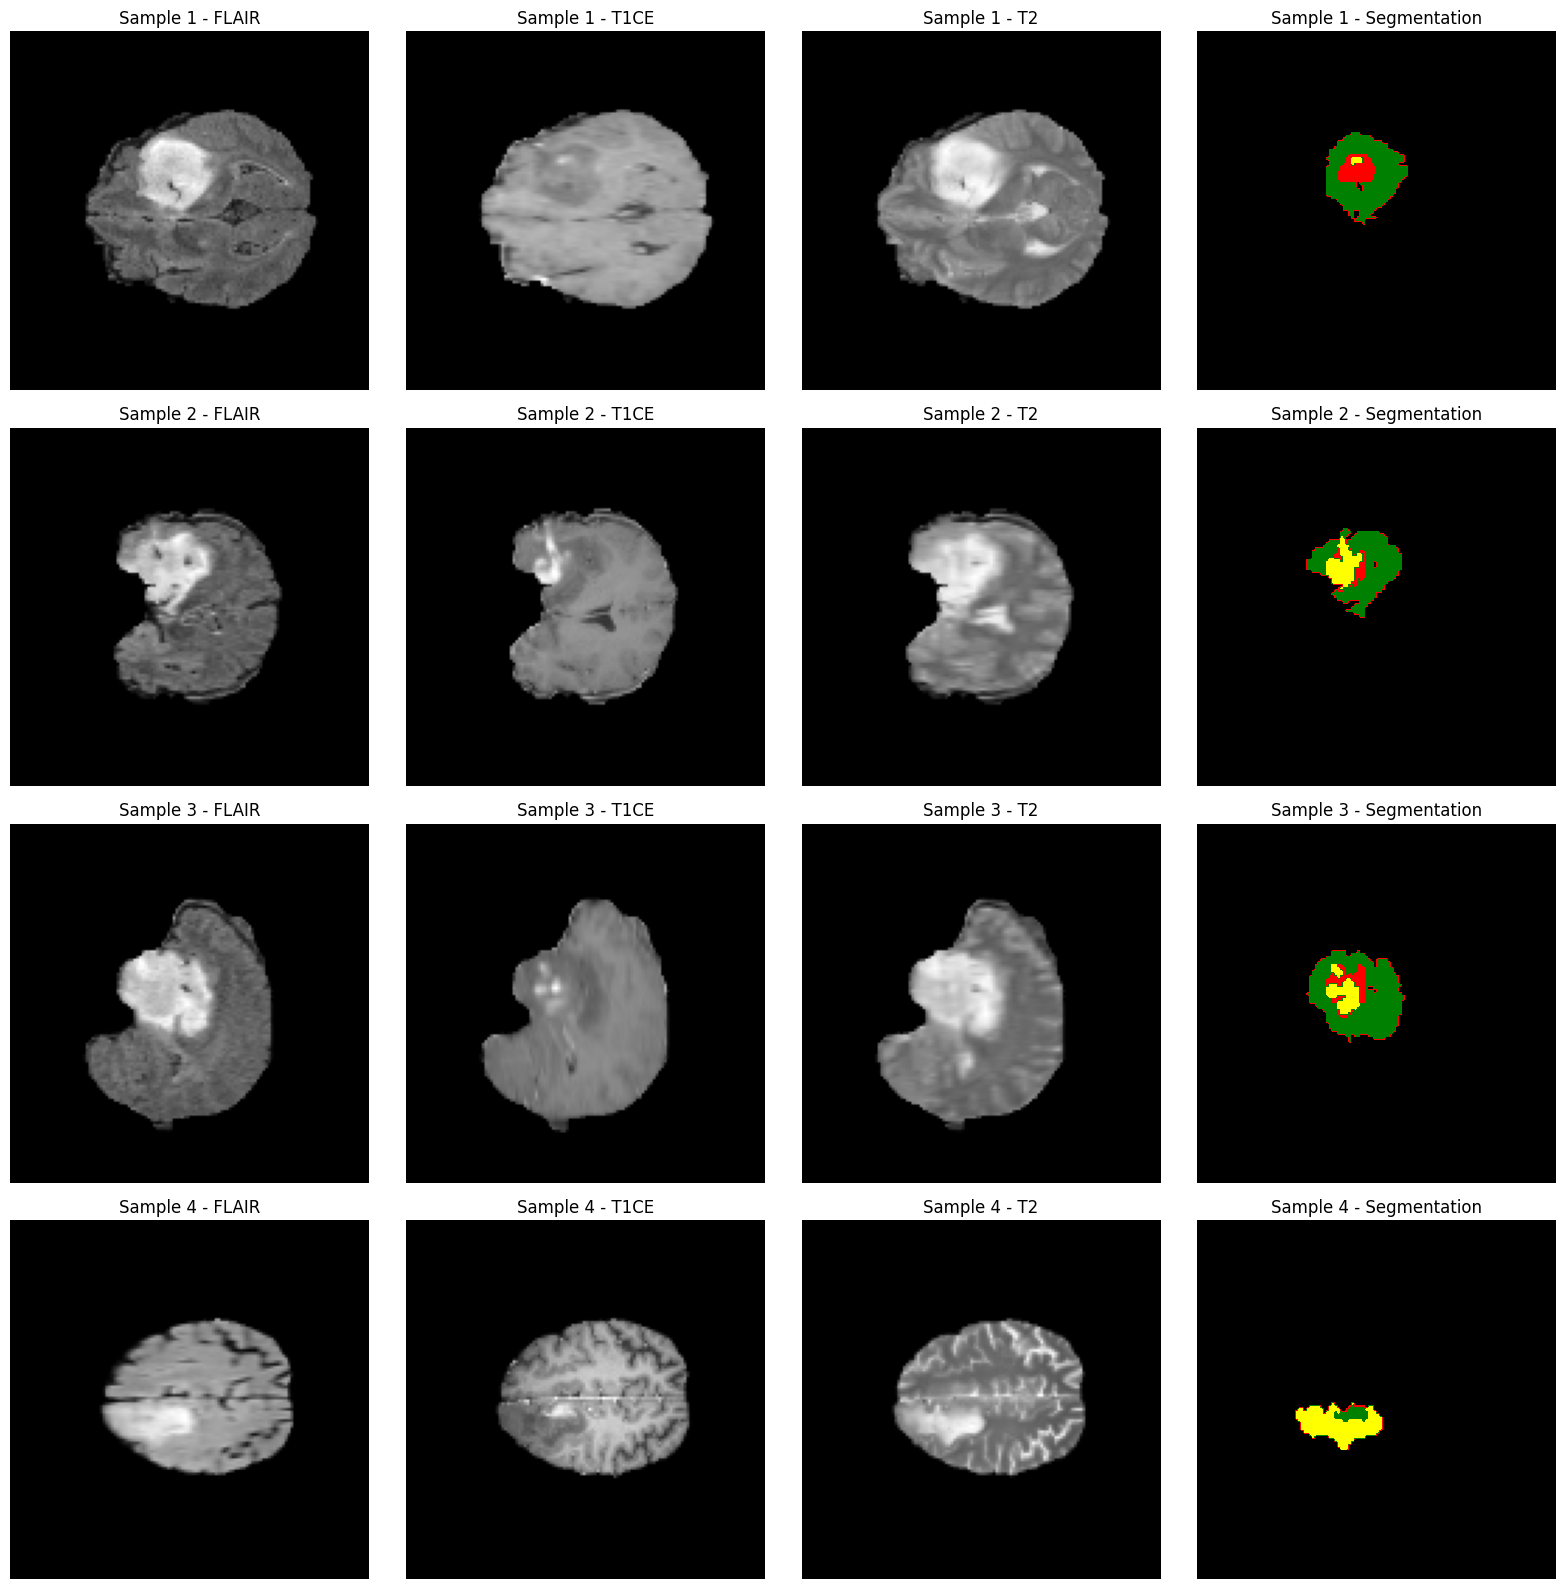

In [5]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))  # 3 inputs + 1 mask

    for i in range(num_samples):
        img, mask = dataset[i] # img: (3, H, W), mask: (H, W)
        img = img.cpu().numpy()
        mask = mask.cpu().numpy()

        flair = img[0]
        t1ce = img[1]
        t2 = img[2]

        axes[i, 0].imshow(flair, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - FLAIR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(t1ce, cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - T1CE')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(t2, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - T2')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask, cmap=ListedColormap(['black', 'red', 'green', 'yellow']))
        axes[i, 3].set_title(f'Sample {i+1} - Segmentation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_dataset, num_samples=4)

# Modified UNet++

In [6]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, rates=[1, 3, 6, 9]):  # [1, 3, 6, 9] or [1, 6, 12, 18] or [1, 12, 24, 36]
        super(ASPP, self).__init__()
        # 1x1 conv
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # Atrous convs
        self.atrous_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rate, dilation=rate)
            for rate in rates
        ])
        # Global average pooling
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.project = nn.Conv2d(out_channels*6, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.atrous_convs[0](x)
        x3 = self.atrous_convs[1](x)
        x4 = self.atrous_convs[2](x)
        x5 = self.atrous_convs[3](x)
        x6 = self.global_pool(x)
        x6 = F.interpolate(x6, size=x.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x1, x2, x3, x4, x5, x6], dim=1)
        x = self.project(x)
        return x

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.residual_conv = None

    def forward(self, x):
        x = x.float()
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.residual_conv:
            residual = self.residual_conv(residual)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out


class NestedUNet(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(NestedUNet, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0]+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1]+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2]+out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3]+out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2+out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3+out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4 + out_channels[1], out_channels[0], out_channels[0])

        # Pooling, ASPP, Upsampling
        self.pool = nn.MaxPool2d(2, 2)
        self.aspp = ASPP(in_channels=1024, out_channels=1024)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Classifier
        self.final = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x4_0 = self.aspp(x4_0)

        # Input = previous conv + upsample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))
        output = self.final(x0_4)
        return output

# Loss

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.eps = torch.finfo(torch.float32).eps

    def forward(self, predict, target):
        predict = F.softmax(predict, dim=1)
        num_classes = predict.shape[1]
        dice = 0.0

        for c in range(num_classes):
            pred_flat = predict[:, c, :, :].contiguous().view(-1)
            target_flat = (target == c).float().view(-1)
            intersection = torch.sum(pred_flat * target_flat)
            union = torch.sum(pred_flat) + torch.sum(target_flat)
            dice_class = (2 * intersection + self.eps) / (union + self.eps)
            dice += 1 - dice_class

        return dice / num_classes


class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, class_weights=None):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=4).permute(0,3,1,2)
        ce = self.ce_loss(predict.float(), ce_target.float())
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [9]:
def IoU(pred_masks, true_masks):
    total_iou = 0
    num_classes = pred_masks.shape[1]
    pred_probs = torch.softmax(pred_masks, dim=1)

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        # true_mask = (true_masks[:, 0, :, :] == class_idx).float()
        true_mask = (true_masks == class_idx).float()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1  # Correct empty prediction
        total_iou += iou

    return total_iou / num_classes

# Training and Testing

In [10]:
def train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every=None):
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_iou = 0.0
            num_samples = 0

            for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = batch
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device, dtype=dtype)

                optimizer.zero_grad()
                out = model(inputs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()

                with torch.no_grad():  # Disable gradient calculation
                    iou = IoU(out, labels)
                    total_iou += iou * inputs.size(0)
                    num_samples += inputs.size(0)

                total_loss += loss.item() * inputs.size(0)

                if print_every is not None and batch_idx % print_every == 0:
                    print('  Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou))

            average_loss = total_loss / num_samples
            average_iou = total_iou / num_samples
            print('  Average Loss: {:.4f}, Average IoU: {:.4f}'.format(average_loss, average_iou))

        torch.save(model, save_path)

    except Exception as e:
        print(e)
        torch.save(model, save_path)

In [11]:
def test(model, val_loader, criterion, device, dtype):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device, dtype=dtype)

            out = model(inputs)
            loss = criterion(out, labels)
            iou = IoU(out, labels)

            total_iou += iou * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

        average_loss = total_loss/num_samples
        average_iou = total_iou/num_samples

        print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [12]:
def compute_class_weights(y_train, num_classes):
    y_flat = y_train.view(-1)
    counts = torch.bincount(y_flat, minlength=num_classes).float()
    total = counts.sum()
    weights = total / counts
    return weights / weights.sum()

print(f"Train class weights ~ {compute_class_weights(y_train, 4)}")
print(f"Test class weights  ~ {compute_class_weights(y_test, 4)}")

Train class weights ~ tensor([0.0043, 0.3861, 0.1883, 0.4213])
Test class weights  ~ tensor([0.0043, 0.3068, 0.1746, 0.5144])


In [13]:
# def pure_bg(dataset):
#     pure_bg = (dataset == 0).view(dataset.size(0), -1).all(dim=1)
#     return pure_bg.sum().item()

# print(f"Number of fully class 0 train images : {pure_bg(y_train)}/{y_train.shape[0]}")
# print(f"Number of fully class 0 test images  : {pure_bg(y_test)}/{y_test.shape[0]}")

In [14]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print_every = None

input_channels = 3
num_classes = 4
class_weights = compute_class_weights(y_train, num_classes).to(device)
dice_weight = 0.5
learning_rate = 0.001
batch_size = 32
num_epochs = 50

save_path = f'checkpoints/runet++aspp_dce{dice_weight:.0e}_invfreqw_adam{learning_rate:.0e}_batch{batch_size}_epoch{num_epochs}_uncrop.pth'.replace('+0', '').replace('-0', '-')
model = NestedUNet(num_classes, input_channels)
class_weights = compute_class_weights(y_train, num_classes).to(device)
criterion = DiceCELoss(dice_weight=dice_weight, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

print(save_path)

checkpoints/runet++aspp_dce5e-1_invfreqw_adam1e-3_batch32_epoch50_uncrop.pth


In [15]:
# from torch.utils.data import Subset
# train_subset = Subset(train_dataset, list(range(8)))
# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every)

Epoch 1/50: 100%|██████████| 24/24 [08:36<00:00, 21.53s/it]


  Average Loss: 0.2925, Average IoU: 0.3839


Epoch 2/50: 100%|██████████| 24/24 [08:20<00:00, 20.85s/it]


  Average Loss: 0.2132, Average IoU: 0.4965


Epoch 3/50: 100%|██████████| 24/24 [08:25<00:00, 21.08s/it]


  Average Loss: 0.1857, Average IoU: 0.5436


Epoch 4/50: 100%|██████████| 24/24 [08:37<00:00, 21.58s/it]


  Average Loss: 0.1790, Average IoU: 0.5539


Epoch 5/50: 100%|██████████| 24/24 [08:37<00:00, 21.57s/it]


  Average Loss: 0.1638, Average IoU: 0.5822


Epoch 6/50: 100%|██████████| 24/24 [08:35<00:00, 21.47s/it]


  Average Loss: 0.1575, Average IoU: 0.5949


Epoch 7/50: 100%|██████████| 24/24 [08:34<00:00, 21.46s/it]


  Average Loss: 0.1478, Average IoU: 0.6130


Epoch 8/50: 100%|██████████| 24/24 [08:35<00:00, 21.46s/it]


  Average Loss: 0.1343, Average IoU: 0.6406


Epoch 9/50: 100%|██████████| 24/24 [08:36<00:00, 21.50s/it]


  Average Loss: 0.1320, Average IoU: 0.6448


Epoch 10/50: 100%|██████████| 24/24 [08:38<00:00, 21.62s/it]


  Average Loss: 0.1321, Average IoU: 0.6458


Epoch 11/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.1251, Average IoU: 0.6601


Epoch 12/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.1202, Average IoU: 0.6687


Epoch 13/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.1202, Average IoU: 0.6697


Epoch 14/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.1113, Average IoU: 0.6890


Epoch 15/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.1032, Average IoU: 0.7082


Epoch 16/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.1037, Average IoU: 0.7053


Epoch 17/50: 100%|██████████| 24/24 [08:34<00:00, 21.46s/it]


  Average Loss: 0.1011, Average IoU: 0.7107


Epoch 18/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0963, Average IoU: 0.7219


Epoch 19/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0949, Average IoU: 0.7256


Epoch 20/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0998, Average IoU: 0.7144


Epoch 21/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0895, Average IoU: 0.7379


Epoch 22/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0907, Average IoU: 0.7360


Epoch 23/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0862, Average IoU: 0.7465


Epoch 24/50: 100%|██████████| 24/24 [08:35<00:00, 21.46s/it]


  Average Loss: 0.0836, Average IoU: 0.7531


Epoch 25/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0870, Average IoU: 0.7444


Epoch 26/50: 100%|██████████| 24/24 [08:34<00:00, 21.46s/it]


  Average Loss: 0.0814, Average IoU: 0.7576


Epoch 27/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0827, Average IoU: 0.7545


Epoch 28/50: 100%|██████████| 24/24 [08:34<00:00, 21.45s/it]


  Average Loss: 0.0766, Average IoU: 0.7697


Epoch 29/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0796, Average IoU: 0.7622


Epoch 30/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0750, Average IoU: 0.7734


Epoch 31/50: 100%|██████████| 24/24 [08:34<00:00, 21.45s/it]


  Average Loss: 0.0732, Average IoU: 0.7787


Epoch 32/50: 100%|██████████| 24/24 [08:34<00:00, 21.43s/it]


  Average Loss: 0.0717, Average IoU: 0.7818


Epoch 33/50: 100%|██████████| 24/24 [08:34<00:00, 21.45s/it]


  Average Loss: 0.0679, Average IoU: 0.7921


Epoch 34/50: 100%|██████████| 24/24 [08:34<00:00, 21.46s/it]


  Average Loss: 0.0707, Average IoU: 0.7845


Epoch 35/50: 100%|██████████| 24/24 [08:34<00:00, 21.44s/it]


  Average Loss: 0.0704, Average IoU: 0.7855


Epoch 36/50: 100%|██████████| 24/24 [08:37<00:00, 21.57s/it]


  Average Loss: 0.0703, Average IoU: 0.7855


Epoch 37/50: 100%|██████████| 24/24 [08:38<00:00, 21.61s/it]


  Average Loss: 0.0692, Average IoU: 0.7884


Epoch 38/50: 100%|██████████| 24/24 [08:38<00:00, 21.62s/it]


  Average Loss: 0.0664, Average IoU: 0.7957


Epoch 39/50: 100%|██████████| 24/24 [08:38<00:00, 21.62s/it]


  Average Loss: 0.0666, Average IoU: 0.7955


Epoch 40/50: 100%|██████████| 24/24 [08:39<00:00, 21.65s/it]


  Average Loss: 0.0680, Average IoU: 0.7920


Epoch 41/50: 100%|██████████| 24/24 [08:39<00:00, 21.63s/it]


  Average Loss: 0.0648, Average IoU: 0.7998


Epoch 42/50: 100%|██████████| 24/24 [08:39<00:00, 21.63s/it]


  Average Loss: 0.0627, Average IoU: 0.8057


Epoch 43/50: 100%|██████████| 24/24 [08:39<00:00, 21.64s/it]


  Average Loss: 0.0631, Average IoU: 0.8044


Epoch 44/50: 100%|██████████| 24/24 [08:39<00:00, 21.66s/it]


  Average Loss: 0.0675, Average IoU: 0.7925


Epoch 45/50: 100%|██████████| 24/24 [08:39<00:00, 21.63s/it]


  Average Loss: 0.0642, Average IoU: 0.8018


Epoch 46/50: 100%|██████████| 24/24 [08:39<00:00, 21.64s/it]


  Average Loss: 0.0624, Average IoU: 0.8064


Epoch 47/50: 100%|██████████| 24/24 [08:39<00:00, 21.65s/it]


  Average Loss: 0.0598, Average IoU: 0.8136


Epoch 48/50: 100%|██████████| 24/24 [08:38<00:00, 21.60s/it]


  Average Loss: 0.0577, Average IoU: 0.8191


Epoch 49/50: 100%|██████████| 24/24 [08:36<00:00, 21.53s/it]


  Average Loss: 0.0586, Average IoU: 0.8166


Epoch 50/50: 100%|██████████| 24/24 [08:40<00:00, 21.71s/it]


  Average Loss: 0.0577, Average IoU: 0.8189


# Visualize Segmentation Results

In [20]:
# Load the saved model
saved_model_path = 'checkpoints/runet++aspp_dce5e-1_invfreqw_adam1e-3_batch32_epoch50_uncrop.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.eval()
loaded_model.to(device)

NestedUNet(
  (conv0_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv1_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2_0): ConvBlock(
    (relu): ReLU(inp

In [21]:
def calculate_metrics(model, dataloader, device=torch.device('cuda'), num_classes=4, eps=torch.finfo(torch.float32).eps):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(imgs)  # (B, C, H, W)
            pred_masks = torch.argmax(outputs, dim=1)  # (B, H, W)

            dice_sum = 0.0
            iou_sum = 0.0
            for c in range(num_classes):
                pred_cls = (pred_masks == c).float()
                true_cls = (masks == c).float()

                intersection = torch.sum(pred_cls * true_cls)
                union = torch.sum((pred_cls + true_cls) > 0)
                iou = (intersection + eps) / (union + eps)
                dice = (2. * intersection + eps) / (torch.sum(pred_cls) + torch.sum(true_cls) + eps)

                dice_sum += dice.item()
                iou_sum += iou.item()

            total_dice += dice_sum / num_classes
            total_iou += iou_sum / num_classes
            num_samples += 1

    return {
        'IoU': total_iou / num_samples,
        'Dice': total_dice / num_samples
    }

In [22]:
# Calculate metrics on the test set
vis_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

metrics = calculate_metrics(loaded_model, vis_test_loader, device=device)
print(f"Test IoU: {metrics['IoU']:.4f}")
print(f"Test Dice: {metrics['Dice']:.4f}")

Test IoU: 0.7428
Test Dice: 0.8441


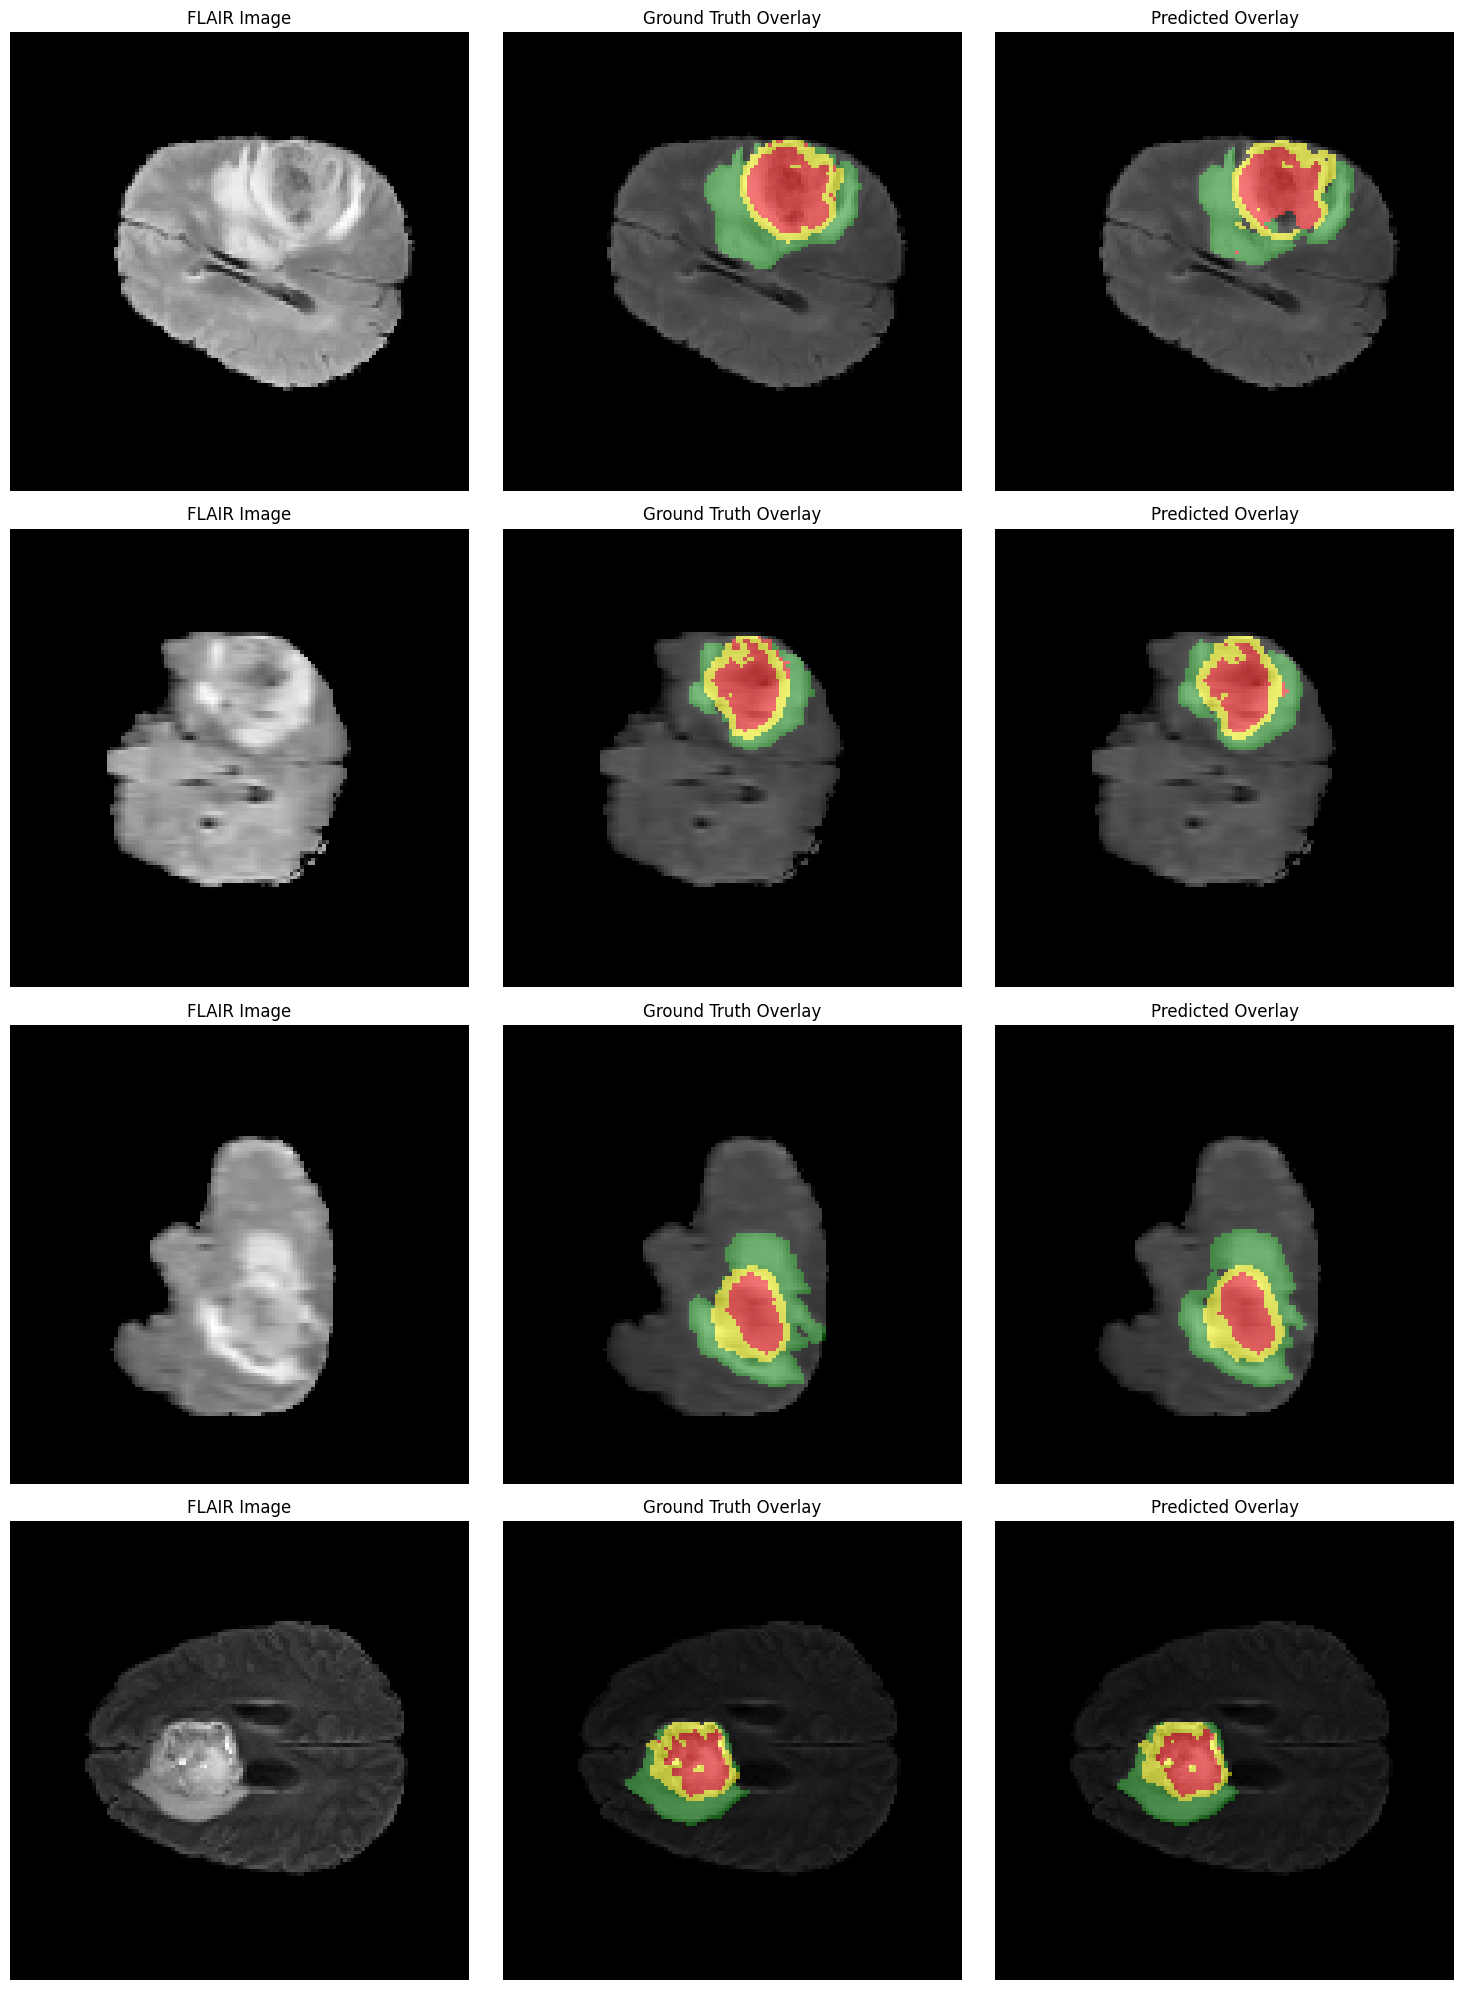

In [23]:
# Visualize segmentation overlays
def visualize_segmentation_overlay(model, dataloader, num_samples=4, device=torch.device('cuda')):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            batch_size = images.size(0)
            for b in range(batch_size):
                if count >= num_samples:
                    break

                image = images[b].to(device).unsqueeze(0)  # [1, 3, H, W]
                mask = masks[b].to(device)  # [H, W]

                output = model(image)  # [1, C, H, W]
                pred_mask = torch.argmax(torch.softmax(output, dim=1), dim=1)[0].cpu().numpy()
                mask_np = mask.cpu().numpy()
                flair_np = image[0, 0].cpu().numpy()

                flair_np = (flair_np - flair_np.min()) / (flair_np.max() - flair_np.min() + 1e-5)
                flair_rgb = np.stack([flair_np]*3, axis=-1)

                cmap = ListedColormap(['black', 'red', 'green', 'yellow'])
                gt_overlay = 0.5 * flair_rgb + 0.5 * cmap(mask_np)[..., :3]
                pred_overlay = 0.5 * flair_rgb + 0.5 * cmap(pred_mask)[..., :3]

                # Plotting
                axes[count, 0].imshow(flair_np, cmap='gray')
                axes[count, 0].set_title("FLAIR Image")
                axes[count, 0].axis('off')

                axes[count, 1].imshow(gt_overlay)
                axes[count, 1].set_title("Ground Truth Overlay")
                axes[count, 1].axis('off')

                axes[count, 2].imshow(pred_overlay)
                axes[count, 2].set_title("Predicted Overlay")
                axes[count, 2].axis('off')

                count += 1
            if count >= num_samples:
                break

    plt.tight_layout()
    plt.show()


visualize_segmentation_overlay(loaded_model, vis_test_loader, num_samples=4, device=device)